## 0. 필요 모듈 import

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
from matplotlib import font_manager,rc
from matplotlib import pyplot as plt
import platform
import seaborn as sns

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. 데이터 불러오기

In [4]:
df_org = pd.read_csv('final서울대공원1019.csv', encoding='cp949')
df_org = df_org.drop(['Unnamed: 0'], axis=1)
df_org = df_org.drop(['일자'], axis=1)
df_org = df_org.set_index('date')
df = df_org.copy()
df.head()

,요일,Daily_Total,Holiday,승차총승객수,하차총승객수,네비게이션,최고기온(℃),최저기온(℃),평균풍속(m/s),최대풍속(m/s),PM2.5,PM10,강수량(mm),행사
date,,,,,,,,,,,,,,
2018-01-01,1,2316,1,2583,2559,175,3.8,-5.1,1.4,3.8,22,39,0.0,0
2018-01-02,2,988,0,3386,3637,82,1.8,-4.3,1.8,4.9,21,35,0.0,0
2018-01-03,3,694,0,2867,3075,50,-0.4,-7.1,2.2,3.5,20,32,0.0,0
2018-01-04,4,671,0,2739,2938,58,-0.7,-8.7,1.4,3.5,27,42,0.0,0
2018-01-05,5,758,0,2985,3148,61,1.6,-5.6,1.7,3.6,34,47,0.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1642 entries, 2018-01-01 to 2022-06-30
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   요일           1642 non-null   int64  
 1   Daily_Total  1642 non-null   int64  
 2   Holiday      1642 non-null   int64  
 3   승차총승객수       1642 non-null   int64  
 4   하차총승객수       1642 non-null   int64  
 5   네비게이션        1642 non-null   int64  
 6   최고기온(℃)      1642 non-null   float64
 7   최저기온(℃)      1642 non-null   float64
 8   평균풍속(m/s)    1642 non-null   float64
 9   최대풍속(m/s)    1642 non-null   float64
 10  PM2.5        1642 non-null   int64  
 11  PM10         1642 non-null   int64  
 12  강수량(mm)      1642 non-null   float64
 13  행사           1642 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 192.4+ KB


## 2. 데이터 탐색

### 2.1. 타겟값 로그변환

<AxesSubplot:title={'center':'Original 서울대공원 일일 방문객 Histogram'}, xlabel='Daily_Total', ylabel='Density'>

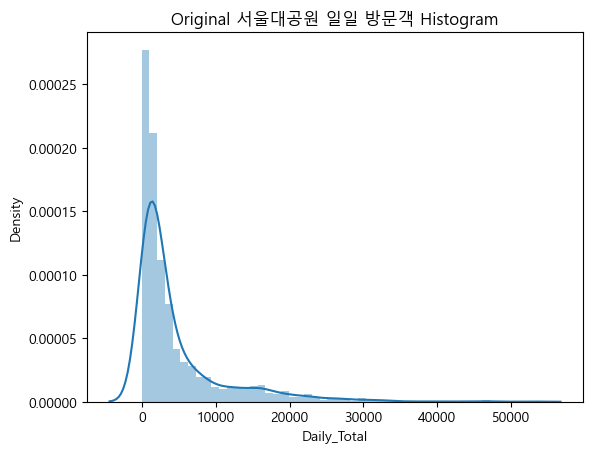

In [6]:
plt.title('Original 서울대공원 일일 방문객 Histogram')
sns.distplot(df['Daily_Total'])

- 데이터가 왼쪽으로 치우쳐져 있음(=오른 꼬리가 긴 형태)
- 로그변환 필요

<AxesSubplot:title={'center':'Log Transformed 서울대공원 일일 방문객 Histogram'}, xlabel='Daily_Total', ylabel='Density'>

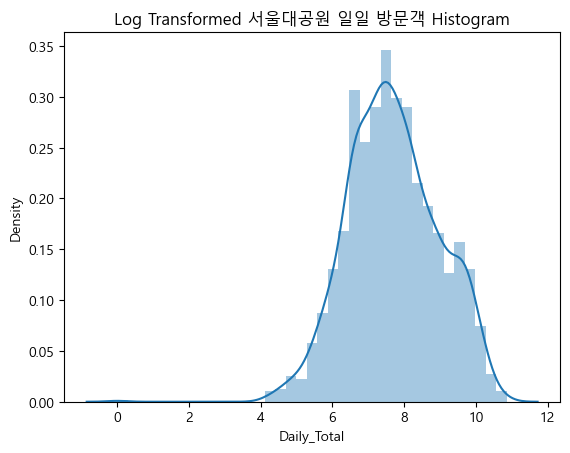

In [7]:
# 결과값을 로그 변환하고 다시 분포도 확인
plt.title('Log Transformed 서울대공원 일일 방문객 Histogram')
log_DailyTotal = np.log1p(df['Daily_Total'])
sns.distplot(log_DailyTotal)

In [8]:
# Daily_Total 로그 변환
original_DailyTotal = df['Daily_Total'] #원래값 저장
df['Daily_Total'] = np.log1p(df['Daily_Total']) #로그변환 값으로 타겟값을 대체

### 2.2. 범주형 데이터 원핫인코딩

In [9]:
# 요일, Holiday, 행사 컬럼 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape:', df.shape)
df_ohe = pd.get_dummies(df, columns=['요일','Holiday','행사'])
print('get_dummies() 수행 후 데이터 Shape:', df_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (1642, 14)
get_dummies() 수행 후 데이터 Shape: (1642, 22)


## 3. 선형회귀모델의 학습/예측/평가

### 3.1. 함수생성 및 데이터 분할

In [10]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models :
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# 단일 모델의 MAE 값 반환
def get_mae(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test , pred)
    print('{0} 로그 변환된 MAE: {1}'.format(model.__class__.__name__,np.round(mae, 3)))
    return mae

# 여러 모델의 MAE 값 반환
def get_maes(models) :
    maes = []
    for model in models :
        mae = get_mae(model)
        maes.append(mae)
    return maes

In [11]:
## 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 타깃과 피처
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

### 3.2. 일반모델 학습/예측/평가

In [12]:
# 일반 선형 회귀
lr_reg = LinearRegression() 
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

Lasso()

In [13]:
models= [lr_reg, ridge_reg, lasso_reg]
get_rmses(models) #학습된 모델 전달하고 rmse값 반환
get_maes(models)

LinearRegression 로그 변환된 RMSE: 0.705
Ridge 로그 변환된 RMSE: 0.705
Lasso 로그 변환된 RMSE: 0.83
LinearRegression 로그 변환된 MAE: 0.513
Ridge 로그 변환된 MAE: 0.513
Lasso 로그 변환된 MAE: 0.594


[0.5132571675416334, 0.5130352575567741, 0.5940301641870229]

- Lasso 모델이 상대적으로 떨어짐
- Ridge 모델과 LR 결과는 동일하게 좋게 나옴

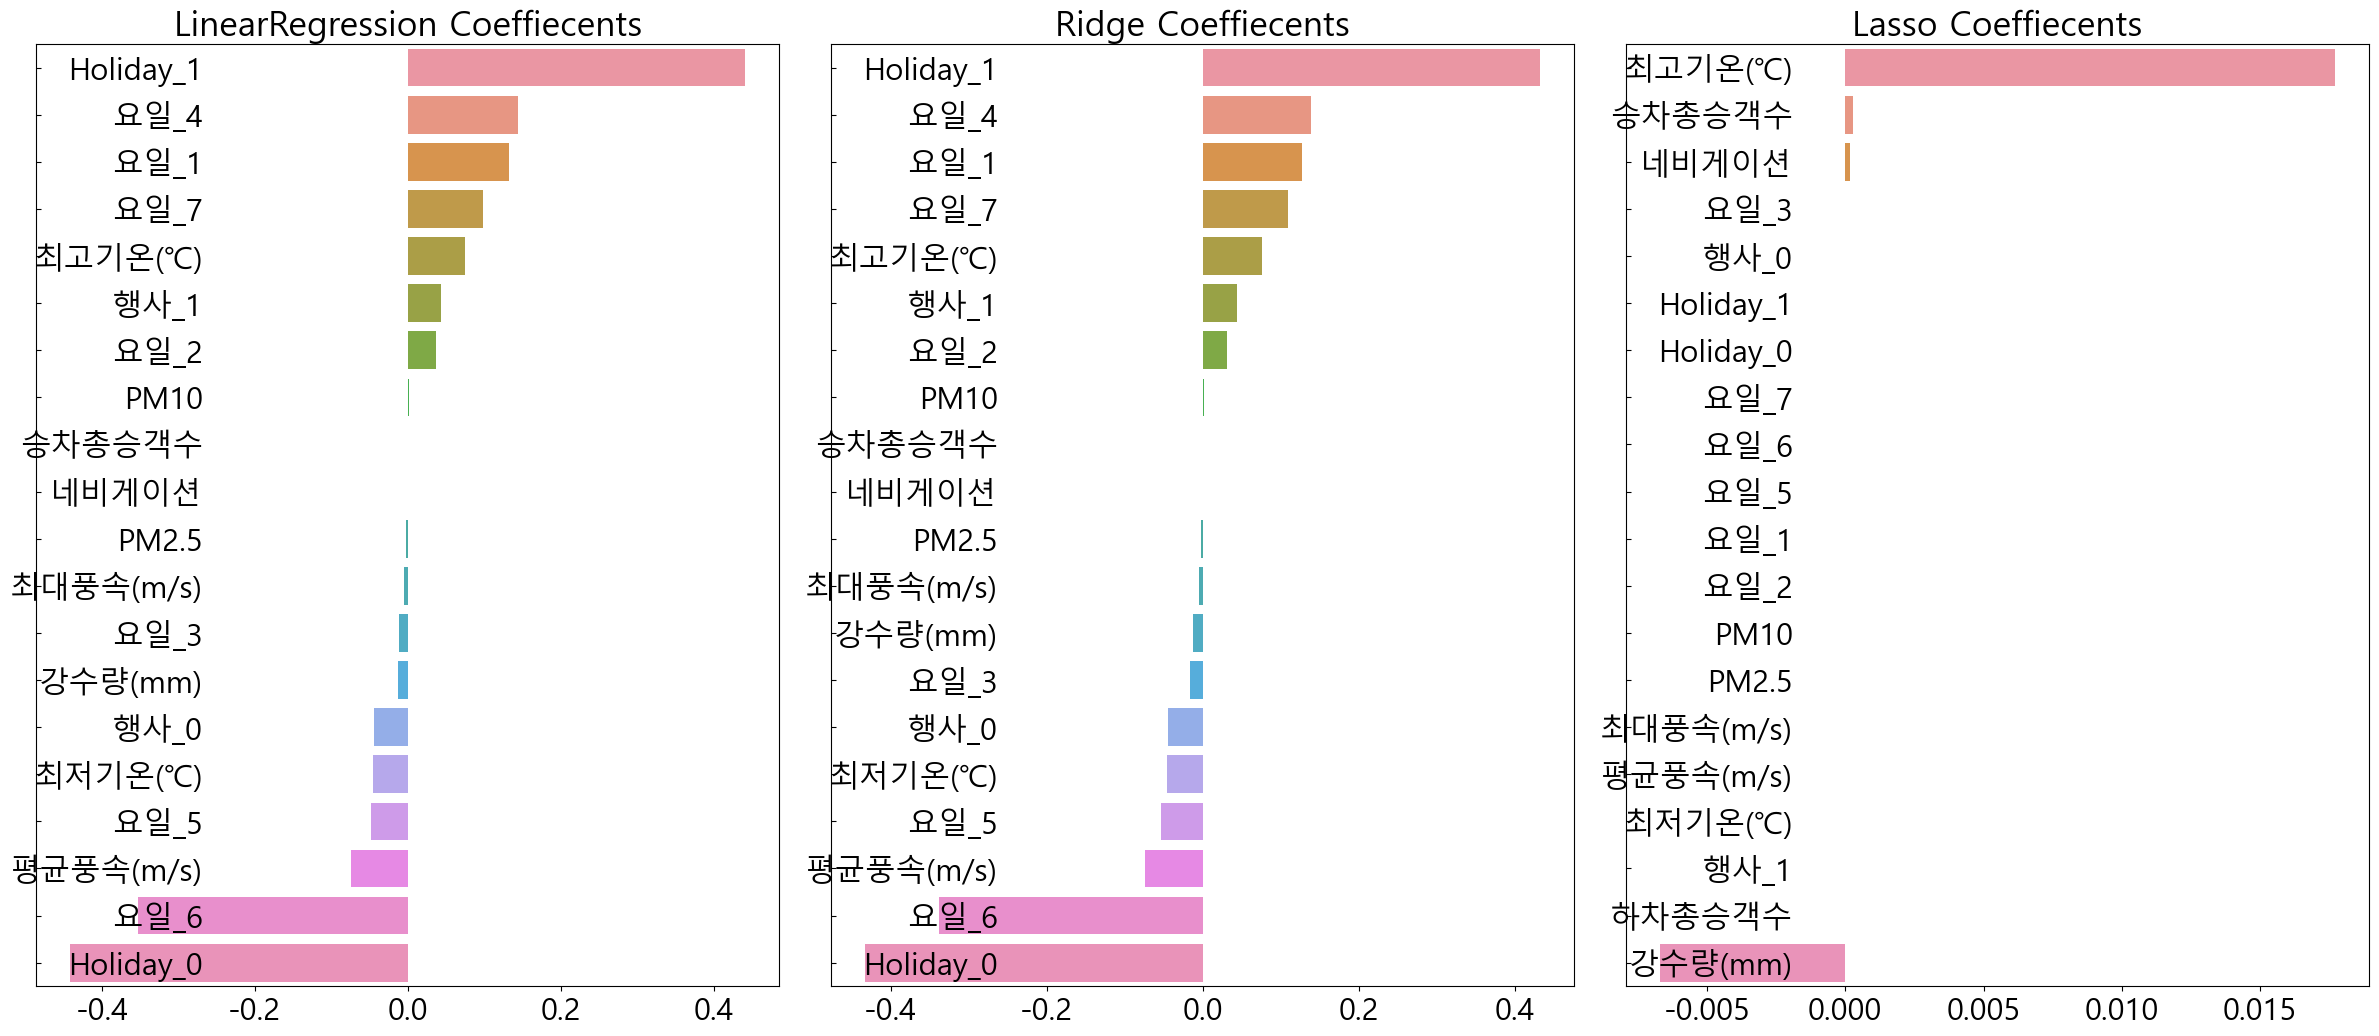

In [14]:
# 회귀계수 시각화

def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [15]:
# 결과
# OLS 기반의 LinearRegression과 Ridge : 회귀 계수가 유사한 형태로 분포
# 라쏘 : 전체적으로 회귀 계수 값이 매우 작음.
#       - 최고기온이 가장 크고, 다른 피처의 회기 계수는 너무 작음
#       - LinearRegression과 Ridge와 다른 회귀 계수 형태
# --> 혹시 학습 데이터의 분할에 문제가 있어서 그런 것인지
# 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고
# 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해서
# 평균 RMSE 측정해보기

### 3.3. 5 폴드 교차검정으로 모델별 RMSE, MAE 출력

In [16]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))      

def get_avg_mae_cv(models) :
    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        mae_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_absolute_error", cv=5))
        mae_avg = np.mean(mae_list)
        print('\n{0} CV MAE 값 리스트: {1}'.format( model.__class__.__name__, np.round(mae_list, 3)))
        print('{0} CV 평균 MAE 값: {1}'.format( model.__class__.__name__, np.round(mae_avg, 3)))        


In [17]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)
get_avg_mae_cv(models)


LinearRegression CV RMSE 값 리스트: [0.737 0.968 0.625 0.874 0.681]
LinearRegression CV 평균 RMSE 값: 0.777

Ridge CV RMSE 값 리스트: [0.736 0.967 0.625 0.874 0.681]
Ridge CV 평균 RMSE 값: 0.777

Lasso CV RMSE 값 리스트: [0.709 1.039 0.792 0.978 0.855]
Lasso CV 평균 RMSE 값: 0.874

LinearRegression CV MAE 값 리스트: [0.741 0.718 0.686 0.829 0.711]
LinearRegression CV 평균 MAE 값: 0.737

Ridge CV MAE 값 리스트: [0.741 0.718 0.686 0.83  0.711]
Ridge CV 평균 MAE 값: 0.737

Lasso CV MAE 값 리스트: [0.738 0.751 0.788 0.877 0.819]
Lasso CV 평균 MAE 값: 0.795



- 5개 폴드 세트로 학습한 후 평가해도 여전히 라쏘 모델이 다른 회귀 모델에 비해 성능이 떨어짐

#### Ridge/Lasso 모델에 대해 alpha 하이퍼 파라미터 튜닝 후 재학습/예측/평가

In [18]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params_rmse(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [19]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [20]:
best_ridge = get_best_params_rmse(ridge_reg,ridge_params)
best_lasso = get_best_params_rmse(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.7842, 최적 alpha:{'alpha': 20}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.7766, 최적 alpha:{'alpha': 0.008}


In [21]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
def get_best_params_mae(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_absolute_error', cv=5)
    grid_model.fit(X_features, y_target)
    mae = (-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 MAE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(mae, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습된 모델 반환

In [22]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [23]:
best_ridge = get_best_params_mae(ridge_reg,ridge_params)
best_lasso = get_best_params_mae(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.5453, 최적 alpha:{'alpha': 15}
Lasso 5 CV 시 최적 평균 MAE 값: 0.5443, 최적 alpha:{'alpha': 0.001}


#### 분할된 트레인/테스트세트로 학습 후 재평가

In [24]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.008)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.008)

In [25]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.705
Ridge 로그 변환된 RMSE: 0.705
Lasso 로그 변환된 RMSE: 0.702


[0.7051410060456847, 0.7046451333322347, 0.7016732032555748]

In [26]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=20)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.005)

In [27]:
# 모든 모델의 MAE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.513
Ridge 로그 변환된 MAE: 0.512
Lasso 로그 변환된 MAE: 0.51


[0.5132571675416334, 0.5118244084103445, 0.5104479332732391]

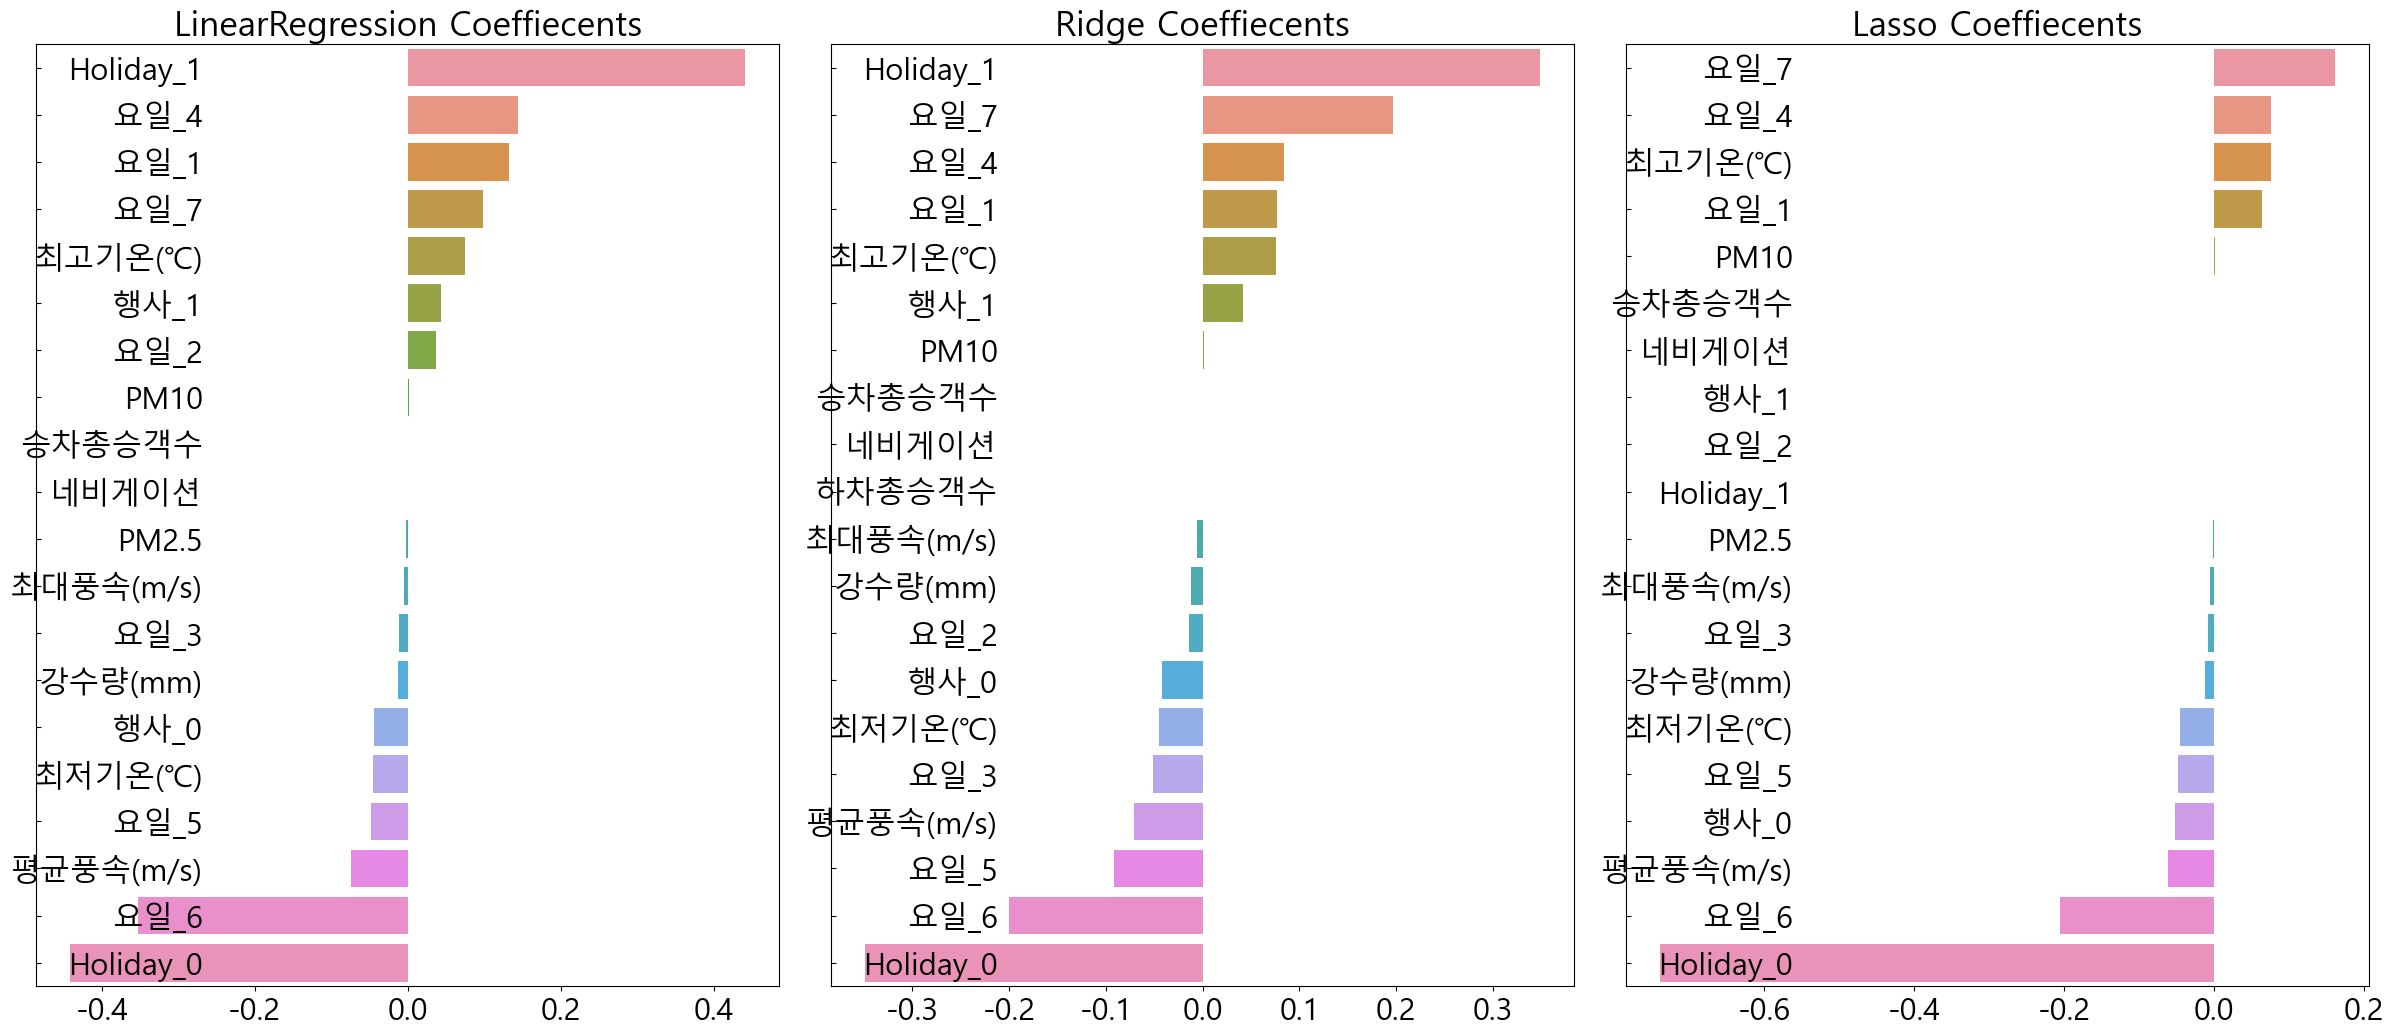

In [28]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 3.4. 데이터세트 추가 가공해서 모델 튜닝 진행
- 1. 피처 데이터 세트의 데이터 분포도 확인
- 2. 이상치 데이터 처리

In [29]:
from scipy.stats import skew

features_index = ['승차총승객수', '하차총승객수', '네비게이션', '최고기온(℃)',
       '최저기온(℃)', '평균풍속(m/s)', '최대풍속(m/s)','PM2.5', 'PM10', '강수량(mm)']

In [30]:
skew_features = df[features_index].apply(lambda x:skew(x)) # 각 컬럼별로 skew() 적용 위해 apply 함수 사용
# skew_features

In [31]:
#skew 정도가 1을 초과하는 컬럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 일반적으로 skew() 함수의 반환값이 1.5이상인 경우 왜곡도가 높다고 판단하지만 상황에 따라 편차는 있음

PM10       6.342835
강수량(mm)    6.015801
하차총승객수     3.150412
승차총승객수     2.892919
네비게이션      2.821130
PM2.5      2.336154
dtype: float64


### 3.5. 왜곡이 심한 컬럼에 로그변환 후 재학습/예측/평가

In [32]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

In [33]:
# 로그 변환 후 다시 왜곡 정도를 확인해 보면
skew_features = df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 여전히 왜곡 정도가 높은 피처가 있지만 더이상 로그변환 하더라도 개선하기 어렵다고 판단
# 그대로 유지하기로 결정

강수량(mm)    2.246488
dtype: float64


In [34]:
# Skew가 높은 피처들을 로그 변환 했으므로 
# 다시 원-핫 인코딩 적용 
# 피처/타겟 데이터 세트 다시 생성
# 최적 alpha 값과 RMSE 출력

# 원-핫 인코딩
df_ohe = pd.get_dummies(df, columns=['요일','Holiday','행사'])

# 피처/타겟 데이터 세트 다시 생성# 
y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)
# 피처 로그 변환된 data, target도 로그변환 되어 있음

In [35]:
# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

In [36]:
best_ridge = get_best_params_rmse(ridge_reg, ridge_params)
best_lasso = get_best_params_rmse(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.6322, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.6325, 최적 alpha:{'alpha': 0.001}


In [37]:
best_ridge = get_best_params_mae(ridge_reg, ridge_params)
best_lasso = get_best_params_mae(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.451, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 MAE 값: 0.4516, 최적 alpha:{'alpha': 0.005}


In [38]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [39]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.554
Ridge 로그 변환된 RMSE: 0.553
Lasso 로그 변환된 RMSE: 0.552


[0.5538112673439908, 0.5531432449094181, 0.5521840397082706]

In [40]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.005)

In [41]:
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.393
Ridge 로그 변환된 MAE: 0.393
Lasso 로그 변환된 MAE: 0.396


[0.3933047940457922, 0.393225130813587, 0.3963053678508562]

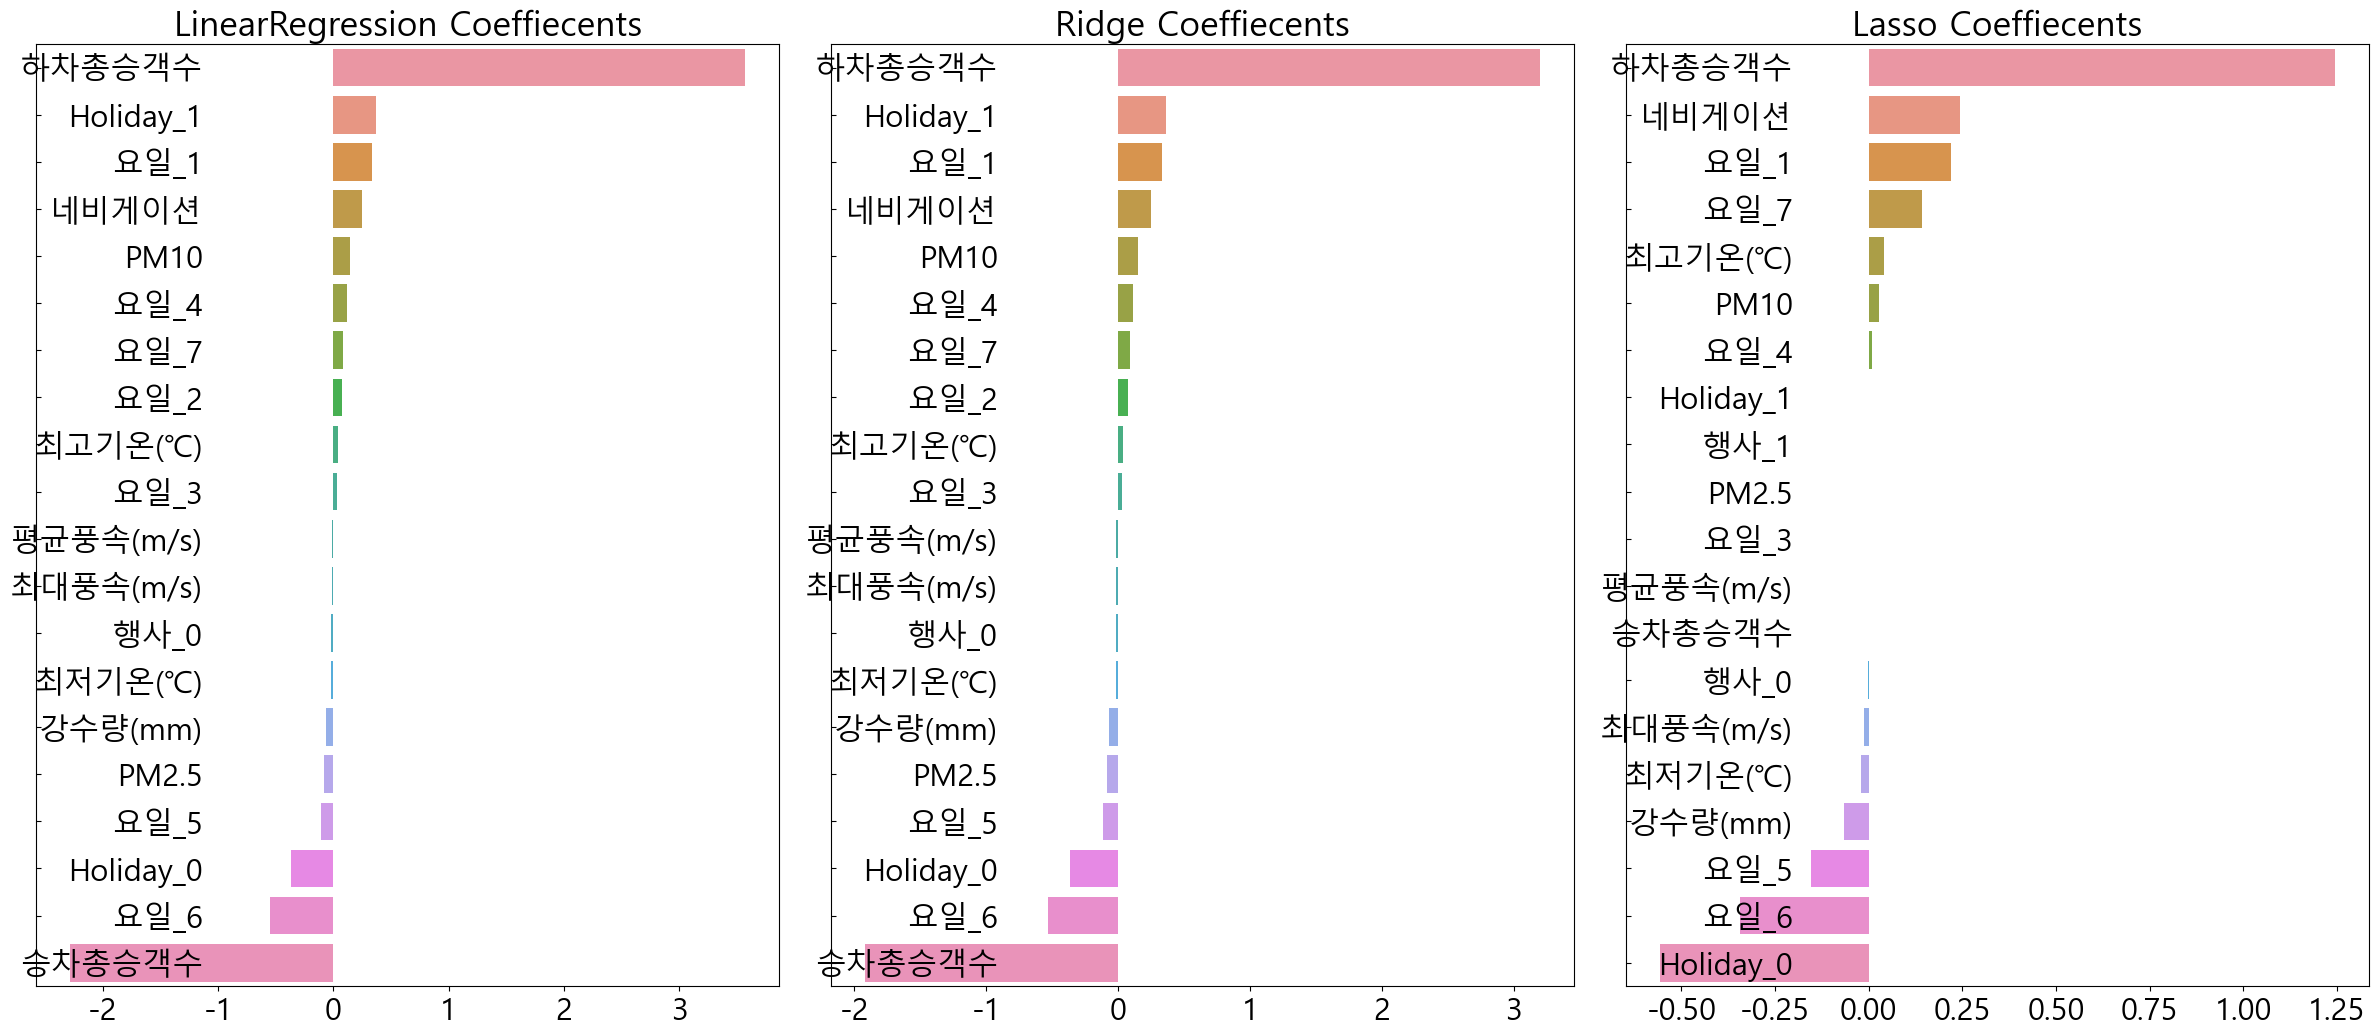

In [42]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
# 하차총승객수가 회귀계수가 가장 높은 피처가 됨

### 3.6. 이상치 제거

In [43]:
df_org.describe()

,요일,Daily_Total,Holiday,승차총승객수,하차총승객수,네비게이션,최고기온(℃),최저기온(℃),평균풍속(m/s),최대풍속(m/s),PM2.5,PM10,강수량(mm),행사
count,1642.000000,1642.000000,1642.000000,1642.00000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,3.996346,4628.727162,0.320341,3982.63581,4162.202192,584.009744,17.925579,8.934653,2.137515,4.542875,19.970767,40.259440,3.378502,0.216809
std,2.000301,6373.644697,0.466750,3016.43271,3160.058656,818.466432,10.550661,10.696636,0.701860,1.277147,15.828695,26.983615,12.158798,0.412197
min,1.000000,0.000000,0.000000,707.00000,750.000000,31.000000,-10.700000,-18.600000,0.600000,1.600000,1.000000,5.000000,0.000000,0.000000
25%,2.000000,886.250000,0.000000,2185.25000,2303.250000,140.000000,9.225000,0.500000,1.700000,3.600000,10.000000,25.000000,0.000000,0.000000
50%,4.000000,2043.000000,0.000000,3103.00000,3250.500000,274.000000,19.150000,8.900000,2.000000,4.400000,16.000000,36.000000,0.000000,0.000000
75%,6.000000,5203.000000,1.000000,4623.75000,4811.500000,540.000000,26.875000,18.500000,2.500000,5.300000,25.000000,49.000000,0.300000,0.000000
max,7.000000,52310.000000,1.000000,31842.00000,37928.000000,6570.000000,39.600000,30.300000,6.000000,11.800000,152.000000,534.000000,176.200000,1.000000


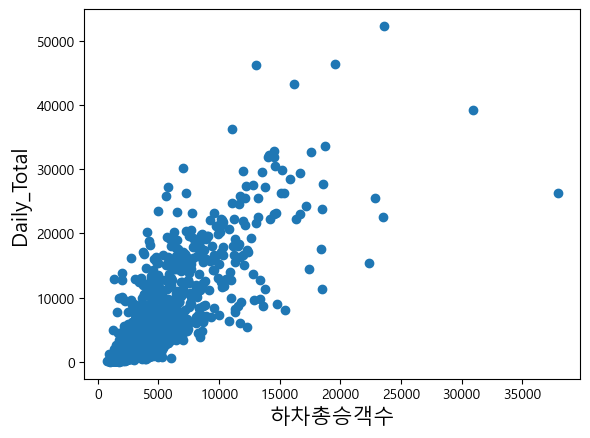

In [44]:
plt.scatter(x=df_org['하차총승객수'], y = df_org['Daily_Total']) # 원본 데이터
plt.ylabel('Daily_Total', fontsize=15)
plt.xlabel('하차총승객수', fontsize=15)
plt.show()

#### 이상치 데이터 제거하고 다시 학습/예측/평가

In [48]:
cond1 = df_ohe['하차총승객수'] > np.log1p(30000)
cond2 = df_ohe['Daily_Total'] < np.log1p(50000)

In [49]:
outlier_index = df_ohe[cond1 & cond2].index
outlier_index

Index(['2019-04-13', '2019-06-01'], dtype='object', name='date')

In [50]:
print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 df_ohe shape:', df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
df_ohe.drop(outlier_index, axis=0, inplace=True)
print('아웃라이어 삭제 후 df_ohe shape:', df_ohe.shape)

아웃라이어 레코드 index : ['2019-04-13' '2019-06-01']
아웃라이어 삭제 전 df_ohe shape: (1642, 22)
아웃라이어 삭제 후 df_ohe shape: (1640, 22)


In [51]:
# df_ohe 기반으로 피처/타깃 데이터 세트 다시 생성하고
# 릿지와 라쏘 모델의 최적화 수행

y_target = df_ohe['Daily_Total']
X_features = df_ohe.drop('Daily_Total',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [53]:
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

In [54]:
best_ridge = get_best_params_rmse(ridge_reg, ridge_params)
best_lasso = get_best_params_rmse(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.6304, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.6316, 최적 alpha:{'alpha': 0.001}


In [56]:
best_ridge = get_best_params_mae(ridge_reg, ridge_params)
best_lasso = get_best_params_mae(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 MAE 값: 0.4498, 최적 alpha:{'alpha': 0.05}
Lasso 5 CV 시 최적 평균 MAE 값: 0.4509, 최적 alpha:{'alpha': 0.005}


In [57]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [58]:
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.582
Ridge 로그 변환된 RMSE: 0.582
Lasso 로그 변환된 RMSE: 0.584


[0.5819309884676561, 0.5820251581214664, 0.5836655210042724]

In [59]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.005)

In [60]:
models = [lr_reg, ridge_reg, lasso_reg]
get_maes(models)

LinearRegression 로그 변환된 MAE: 0.406
Ridge 로그 변환된 MAE: 0.407
Lasso 로그 변환된 MAE: 0.406


[0.4061300866759843, 0.406643928894832, 0.40634724665274224]

- 결과: 이상치 제거 후 RMSE, MAE값은 오히려 더 높아짐

## 4. 회귀 트리 학습/예측/평가

- df_ohe 되돌리기

In [65]:
df_ohe = pd.get_dummies(df, columns=['요일','Holiday','행사'])

In [66]:
df_ohe

,Daily_Total,승차총승객수,하차총승객수,네비게이션,최고기온(℃),최저기온(℃),평균풍속(m/s),최대풍속(m/s),PM2.5,PM10,...,요일_2,요일_3,요일_4,요일_5,요일_6,요일_7,Holiday_0,Holiday_1,행사_0,행사_1
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,7.748029,7.857094,7.847763,5.170484,3.8,-5.1,1.4,3.8,3.135494,3.688879,...,0,0,0,0,0,0,0,1,1,0
2018-01-02,6.896694,8.127700,8.199189,4.418841,1.8,-4.3,1.8,4.9,3.091042,3.583519,...,1,0,0,0,0,0,1,0,1,0
2018-01-03,6.543912,7.961370,8.031385,3.931826,-0.4,-7.1,2.2,3.5,3.044522,3.496508,...,0,1,0,0,0,0,1,0,1,0
2018-01-04,6.510258,7.915713,7.985825,4.077537,-0.7,-8.7,1.4,3.5,3.332205,3.761200,...,0,0,1,0,0,0,1,0,1,0
2018-01-05,6.632002,8.001690,8.054840,4.127134,1.6,-5.6,1.7,3.6,3.555348,3.871201,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,9.843207,8.341410,8.352319,4.718499,28.1,24.8,2.6,5.0,2.302585,2.995732,...,0,0,0,0,0,1,0,1,1,0
2022-06-27,6.131226,7.462789,7.526179,4.682131,28.1,25.4,2.8,6.0,1.609438,2.564949,...,0,0,0,0,0,0,1,0,1,0
2022-06-28,6.003887,7.612337,7.668094,4.897840,27.9,25.7,5.8,9.9,1.609438,2.833213,...,1,0,0,0,0,0,1,0,1,0


In [82]:
# 비선형회귀 간단하게 돌려보니 랜덤포레스트가 제일 잘나옴
# 여기서 다시 돌려보니까 점수가 생각보다 좋지 않네!

from sklearn.ensemble import RandomForestRegressor

rf_params = {'random_state':[0],'n_estimators':[500,1000]}
rf_res = RandomForestRegressor(n_estimators=1000)
best_rf = get_best_params_rmse(rf_res,rf_params)

rf_params = {'random_state':[0],'n_estimators':[500,1000]}
rf_res = RandomForestRegressor(n_estimators=1000)
best_rf = get_best_params_mae(rf_res,rf_params)

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값: 0.6505, 최적 alpha:{'n_estimators': 1000, 'random_state': 0}
RandomForestRegressor 5 CV 시 최적 평균 MAE 값: 0.4546, 최적 alpha:{'n_estimators': 1000, 'random_state': 0}


## 5. 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

- 선형회귀 Ridge / Lasso 혼합

In [87]:
# 최종 혼합 모델과 개별 모델의 RMSE 값 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))
        
def get_mae_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mae = mean_absolute_error(y_test , pred_value)
        print('{0} 모델의 MAE: {1}'.format(key, mae))

In [96]:
# 개별 모델 학습
ridge_reg = Ridge(alpha=0.05)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.005)
lasso_reg.fit(X_train, y_train)
# 개별모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

In [97]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출 - ridge:60% / lasso:40%
pred = ridge_pred*0.6 + lasso_pred*0.4

In [98]:
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)
get_mae_pred(preds)

최종 혼합 모델의 RMSE: 0.5811044091906893
Ridge 모델의 RMSE: 0.5820251581214664
Lasso 모델의 RMSE: 0.5824803242890814
최종 혼합 모델의 MAE: 0.4054700819950697
Ridge 모델의 MAE: 0.406643928894832
Lasso 모델의 MAE: 0.40634724665274224


- 비선형회귀 XGBoost와 LightGBM 혼합

In [99]:
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
lgbm_reg = LGBMRegressor(n_estimators=1000)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

In [100]:
pred = xgb_pred*0.5 + lgbm_pred*0.5
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)
get_mae_pred(preds)

최종 혼합 모델의 RMSE: 0.5785747911174772
XGBM 모델의 RMSE: 0.5939431323869143
LGBM 모델의 RMSE: 0.5966942376453286
최종 혼합 모델의 MAE: 0.3682616689811921
XGBM 모델의 MAE: 0.38066398071351976
LGBM 모델의 MAE: 0.39256139472250473


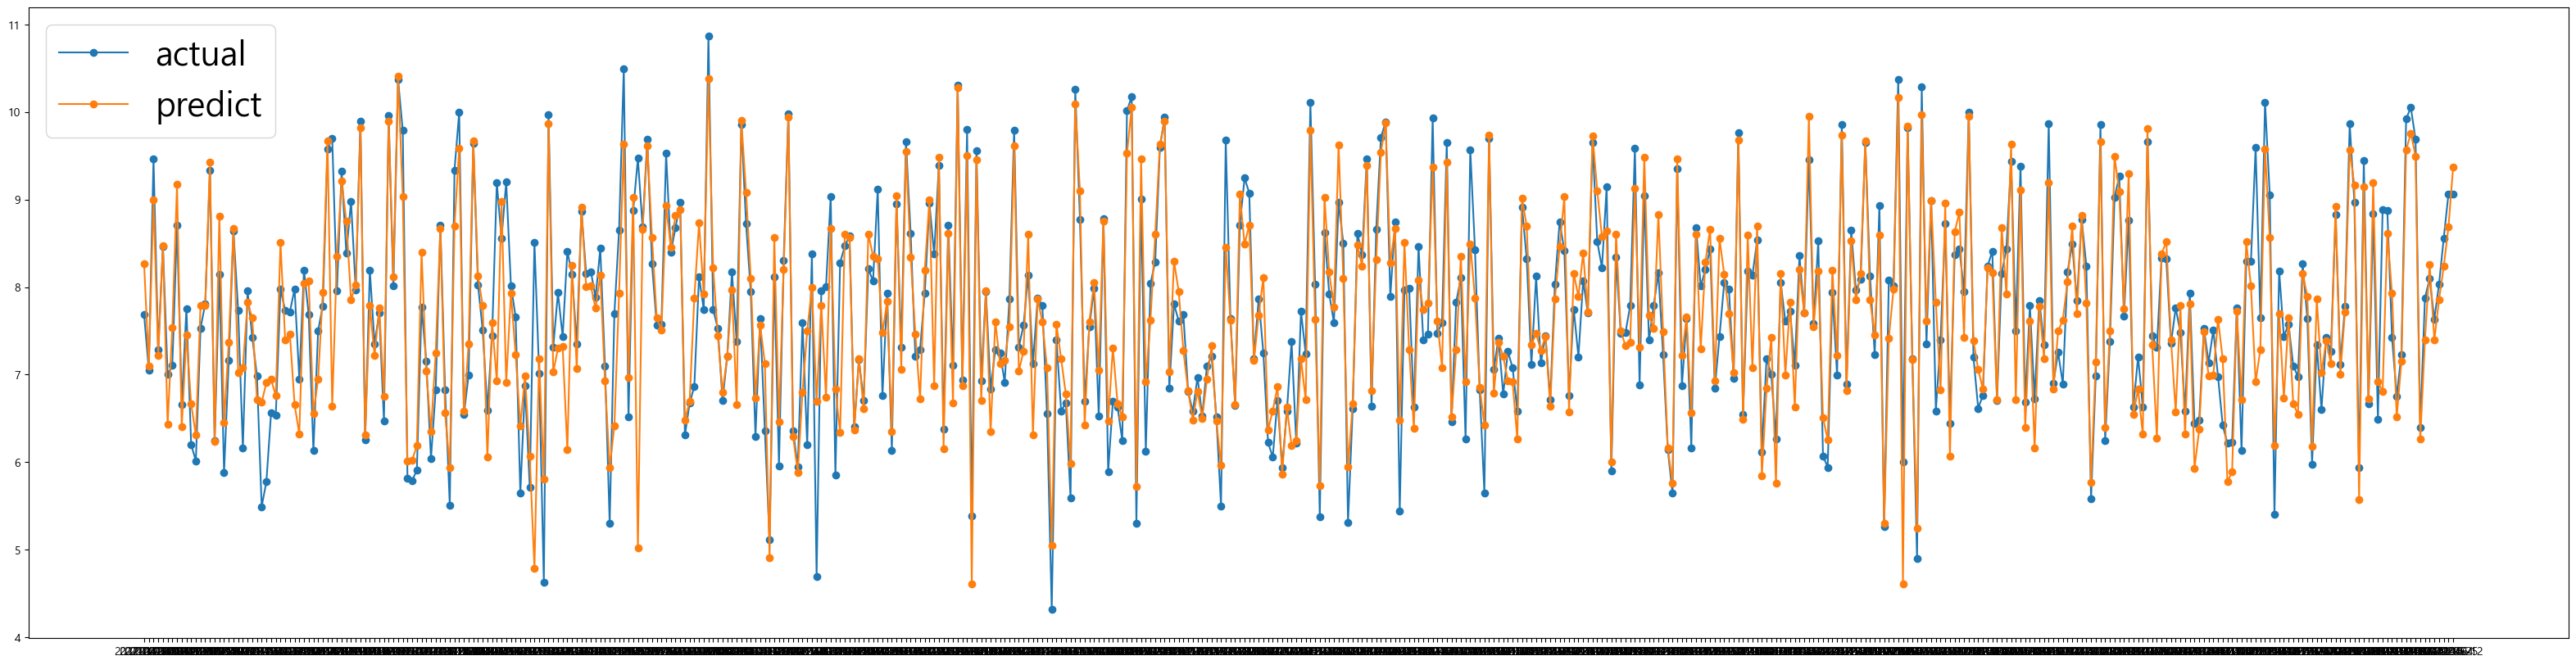

In [105]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)

ax1.plot(y_test, marker = "o" , label = "actual") # 100일간 데이터 
ax1.plot(pred, marker = "o", label = "predict") # 100일간 데이터 
ax1.legend(prop={'size':30})

## 6. ElasticNet

In [123]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
#     coeff_df = pd.DataFrame()
#     if verbose: print('#####', model_name,'#####')
#     for param in params:
#         if model_name == 'Ridge': model = Ridge(alpha=param)
#         elif model_name == 'Lasso': model = Lasso(alpha=param)
#         elif model_name == 'ElasitcNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
#         neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
#         avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
#         print('alpha {0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
#         # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
#         model.fit(X_data_n, y_target_n)

In [130]:
# 엘라스틱넷에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07,0.1,0.5,1,3]
for alpha in elastic_alphas:
    elasticnet = ElasticNet(alpha=alpha)
    
    neg_mse_scores = cross_val_score(elasticnet, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
    neg_mae_scores = cross_val_score(elasticnet, X_features, y_target, scoring='neg_mean_absolute_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    avg_mae = np.mean(-1*neg_mae_scores)
    print('alpha {0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))
    print('alpha {0}일 때 5폴드 세트의 평균 MAE: {1:.3f}'.format(alpha, avg_mae))

alpha 0.07일 때 5폴드 세트의 평균 RMSE: 0.650
alpha 0.07일 때 5폴드 세트의 평균 MAE: 0.470
alpha 0.1일 때 5폴드 세트의 평균 RMSE: 0.661
alpha 0.1일 때 5폴드 세트의 평균 MAE: 0.479
alpha 0.5일 때 5폴드 세트의 평균 RMSE: 0.866
alpha 0.5일 때 5폴드 세트의 평균 MAE: 0.677
alpha 1일 때 5폴드 세트의 평균 RMSE: 1.107
alpha 1일 때 5폴드 세트의 평균 MAE: 0.882
alpha 3일 때 5폴드 세트의 평균 RMSE: 1.173
alpha 3일 때 5폴드 세트의 평균 MAE: 0.944


- ElasticNet은 기대했던 것보다 성능이 그렇게까지 좋진 않아보입니다..

## 7. 스태킹 앙상블 모델

In [131]:
from sklearn.model_selection import KFold #트레인데이터를 학습/검증 세트로 분리하기 위해 필요
from sklearn.metrics import mean_absolute_error

In [132]:
# 개별 기반 모델(1개의 모델) 최종 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
# Fold를 사용하도록 구성(사용자정의함수- 구성방법은 개발자가 결정)
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds) :
    # 지정된 n_folds 값으로 KFold 객체 생성
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)
    # 데이터 분할이 아닌 행 인덱스만 분할함
    
    # 최종모델이 사용할 학습 데이터를 위한 초기 구성 - 넘파이배열로 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1)) # 0으로 저장되어 있는 빈 배열
    test_pred = np.zeros((X_test_n.shape[0],n_folds)) # 0으로 저장되어 있는 빈 배열
    print(model.__class__.__name__ , ' model 시작 ')
    
    # kf.split(X_train_n) 데이터의 인덱스를 분할한 결과 반환
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
       #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] # 학습 데이터
        y_tr = y_train_n[train_index] # 학습 데이터 타겟
        X_te = X_train_n[valid_index] # 검증 데이터
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr) # 개별모델로 학습
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # 예측데이터 저장-검증데이터에 대해서 예측 진행
        
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n) # 테스트 데이터에 대해 예측해서 저장
        
    # 테스트 데이터를 폴드세트의 평균으로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [133]:
# 생성한 함수가 ndarray를 인자로 사용하므로 DF를 ndarray로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [134]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [135]:
# 각 개별 모델이 반환한 학습용피처 데이터와 테스트용피터 데이터 세트를 결합해서 최종데이터세트 생성
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

In [138]:
# 최종 모델 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.005)

In [143]:
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, final)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)
print('스태킹 회귀 모델의 최종 MAE 값은:', mae)

스태킹 회귀 모델의 최종 RMSE 값은: 0.5339214475252343
스태킹 회귀 모델의 최종 MAE 값은: 0.340987959716779


In [141]:
# # 최종 모델 릿지 모델을 적용
# meta_model_ridge = Ridge(alpha=0.05)
# meta_model_ridge.fit(Stack_final_X_train, y_train)
# final = meta_model_ridge.predict(Stack_final_X_test)
# mse = mean_squared_error(y_test , final)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, final)
# print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)
# print('스태킹 회귀 모델의 최종 MAE 값은:', mae)

스태킹 회귀 모델의 최종 RMSE 값은: 0.5342571898623283
스태킹 회귀 모델의 최종 MAE 값은: 0.34125426338813475


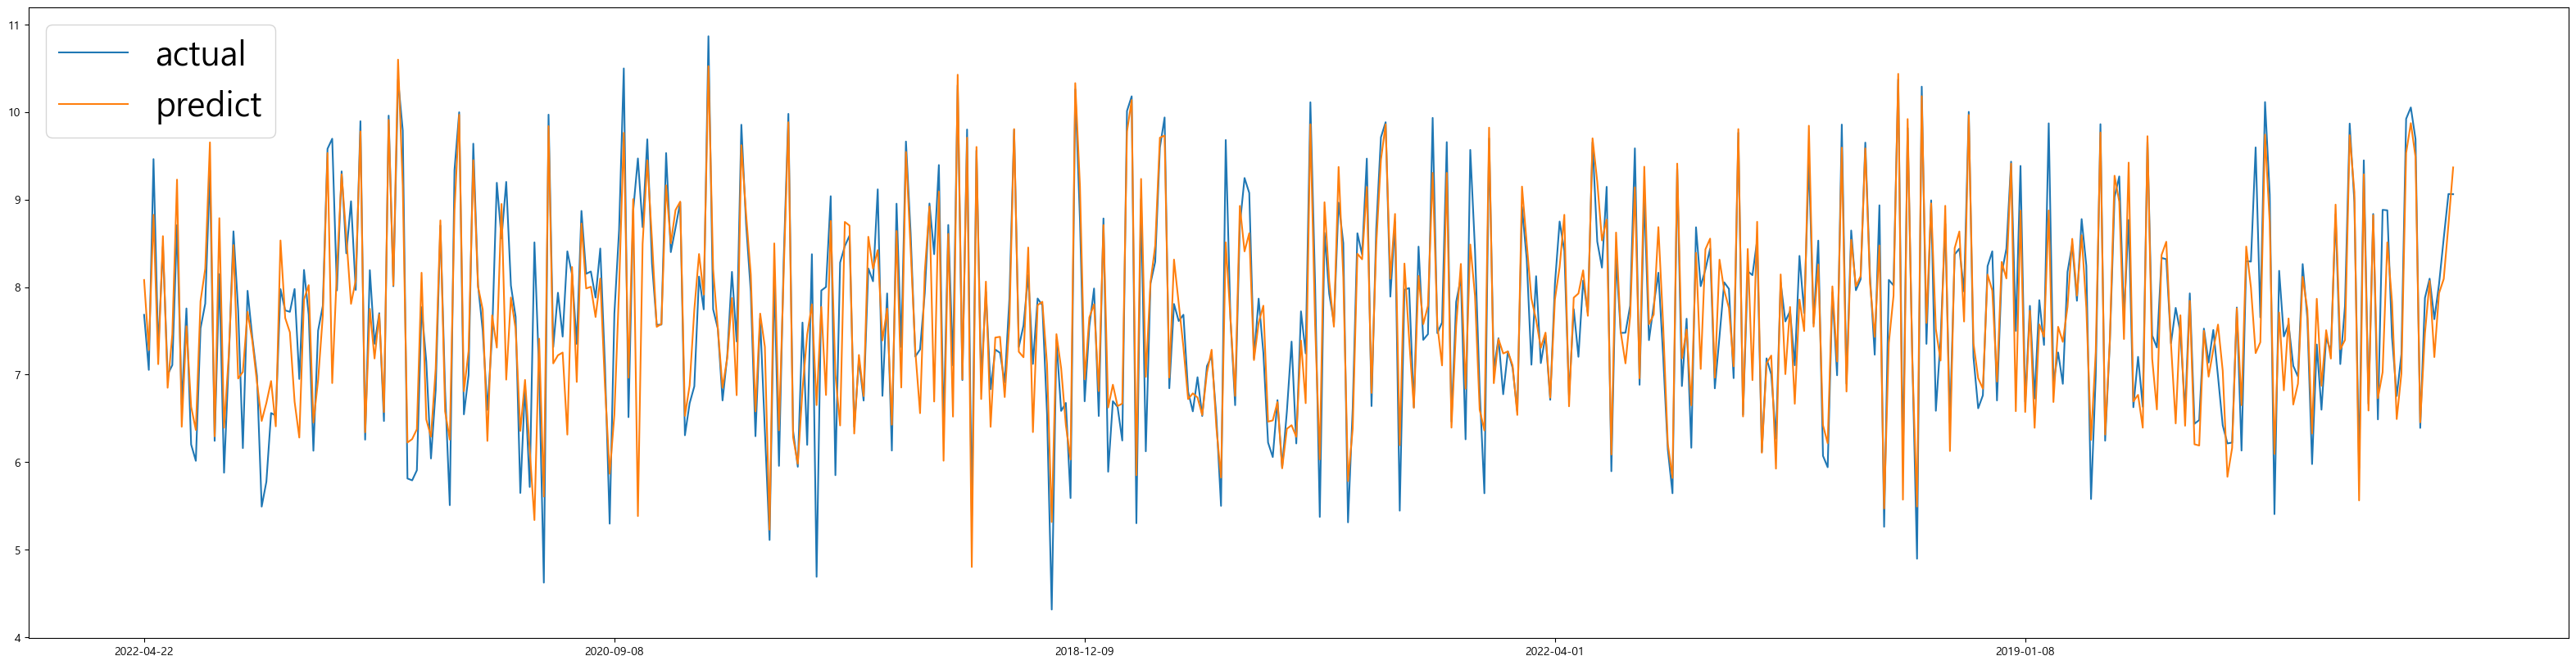

In [145]:
fig, ax1  = plt.subplots(nrows=1)
fig.set_size_inches(40,10)

plt.xticks([0,100,200,300,400], label=["100","200","300","400"])

ax1.plot(y_test, label = "actual") 
ax1.plot(final, label = "predict") 
ax1.legend(prop={'size':30})